# Train a Bayesian Layer Model for MNIST classification

In this notebook, we will train an MNIST convolutional classifier with a Bayesian last layer. First, we train a determinstic classifier to obtain a MAP estimate of the weights. Then, we replace the last layer of this model with a Bayesian last layer and train the layer using Stochastic Gradient Hamiltonian Monte Carlo (we keep the backbone fixed). 

## Setup


Import libraries

In [1]:
import importlib
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

import models.BLL
import models.mnist_classifier_BLL
import train
import sampler


Set the configuration

In [31]:
# 1. Configuration
class Config:
    # Data
    batch_size = 512
    
    # Backbone training
    backbone_epochs = 12
    backbone_lr = 0.001
    backbone_patience = 5
    
    # BLL training
    bll_epochs = 100
    bll_lr = 0.5e-2
    bll_base_C = 0.05
    bll_gauss_sig = 0.1
    
    # SGHMC parameters
    burn_in = 10
    re_burn = 1e7
    sim_steps = 2      # Save model every N epochs
    N_saves = 20       # Maximum ensemble size
    resample_its = 10  # Resample momentum every N iterations
    resample_prior_its = 45
    nb_its_dev = 1     # Evaluate on validation set every epoch
    
    # Hardware
    device = 'cuda' if torch.cuda.is_available() \
    else 'mps' if torch.backends.mps.is_available() \
    else 'cpu'
    
cfg = Config()

Load the Datasets

In [45]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# Split training set into train and validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=cfg.batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)

Create a models and results directory if it doesn't exist

In [33]:
models_dir = '../model_saves'
results_dir = '../results'
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

## Training
We'll start with the backbone training.

### Backbone 

Load model

In [34]:
from models.mnist_classifier_BLL import MNISTClassifierBLL
importlib.reload(models.mnist_classifier_BLL)


backbone = MNISTClassifierBLL(device=cfg.device)
print(f"Backbone will run on: {cfg.device}")

Backbone will run on: mps


Train model


Backbone Network:
it 0/12, Jtr = 0.000923, err = 0.000285,    time: 14.251619 seconds

    Jdev = 0.000236, err = 0.000069

best validation error
it 1/12, Jtr = 0.000176, err = 0.000055,    time: 9.338163 seconds

    Jdev = 0.000162, err = 0.000050

best validation error
it 2/12, Jtr = 0.000121, err = 0.000038,    time: 9.858170 seconds

    Jdev = 0.000103, err = 0.000032

best validation error
it 3/12, Jtr = 0.000085, err = 0.000026,    time: 9.598193 seconds

    Jdev = 0.000096, err = 0.000030

best validation error
it 4/12, Jtr = 0.000072, err = 0.000022,    time: 9.545995 seconds

    Jdev = 0.000082, err = 0.000024

best validation error
it 5/12, Jtr = 0.000058, err = 0.000019,    time: 12.035778 seconds

    Jdev = 0.000078, err = 0.000025

it 6/12, Jtr = 0.000051, err = 0.000017,    time: 10.044064 seconds

    Jdev = 0.000087, err = 0.000026

it 7/12, Jtr = 0.000042, err = 0.000013,    time: 26.187811 seconds

    Jdev = 0.000070, err = 0.000022

best validation error
it 8/

<Figure size 640x480 with 0 Axes>

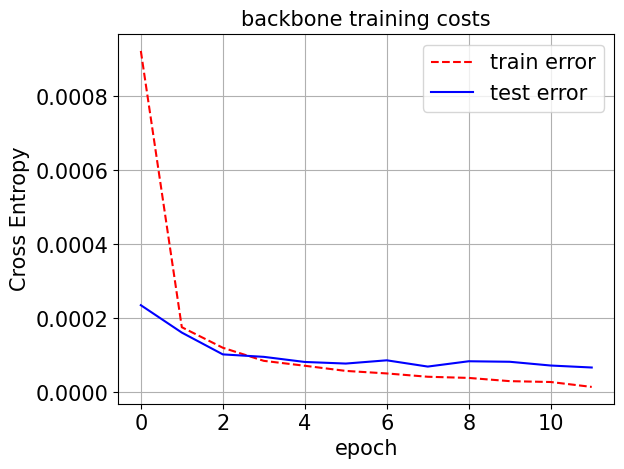


Backbone training completed! Best validation error: 0.0000


In [35]:
from train import train_backbone
importlib.reload(train)

cost_tr, cost_dev, err_tr, err_dev, best_err = train_backbone(
    net=backbone,
    name='mnist_backbone',
    batch_size=cfg.batch_size,
    nb_epochs=cfg.backbone_epochs,
    trainset=trainset,
    valset=valset,
    device=cfg.device,
    lr=cfg.backbone_lr,
    patience=cfg.backbone_patience,
    model_saves_dir=models_dir
)

print(f"\nBackbone training completed! Best validation error: {best_err:.4f}")

### Load weights


In [ ]:
backbone.load_weights(models_dir + '/backbone_checkpoint.pth')

## Bayesian Last Layer
Next we'll train the Bayesian last layer on the penultimate layer representations of the backbone.

### Load the model

In [36]:
from models.BLL import BayesianLastLayerCat
importlib.reload(models.BLL)

bll = BayesianLastLayerCat(
    backbone=backbone,
    input_dim=256,  # Matches backbone's encoder output
    output_dim=10,  # MNIST classes
    N_train=len(trainset),
    lr=cfg.bll_lr,
    base_C=cfg.bll_base_C,
    gauss_sig=cfg.bll_gauss_sig,
    device=cfg.device
)


Network:

Train:
  init cost variables:
it 0/100, Jtr_pred = 0.001827, err = 0.228729,    time: 9.512891 seconds

 [update_lr] Learning rate: 0.004950  (epoch 0)
    Jdev = 0.000539, err = 0.000048

best validation error
it 1/100, Jtr_pred = 0.000231, err = 0.007417,    time: 6.183874 seconds

 [update_lr] Learning rate: 0.004901  (epoch 1)
    Jdev = 0.000138, err = 0.000024

best validation error
it 2/100, Jtr_pred = 0.000073, err = 0.002833,    time: 5.660263 seconds

 [update_lr] Learning rate: 0.004851  (epoch 2)
    Jdev = 0.000085, err = 0.000020

best validation error
it 3/100, Jtr_pred = 0.000043, err = 0.002208,    time: 6.567295 seconds

 [update_lr] Learning rate: 0.004803  (epoch 3)
    Jdev = 0.000072, err = 0.000020

best validation error
it 4/100, Jtr_pred = 0.000031, err = 0.001792,    time: 6.498125 seconds

 [update_lr] Learning rate: 0.004755  (epoch 4)
    Jdev = 0.000067, err = 0.000019

best validation error
it 5/100, Jtr_pred = 0.000026, err = 0.001646,    time

<Figure size 640x480 with 0 Axes>

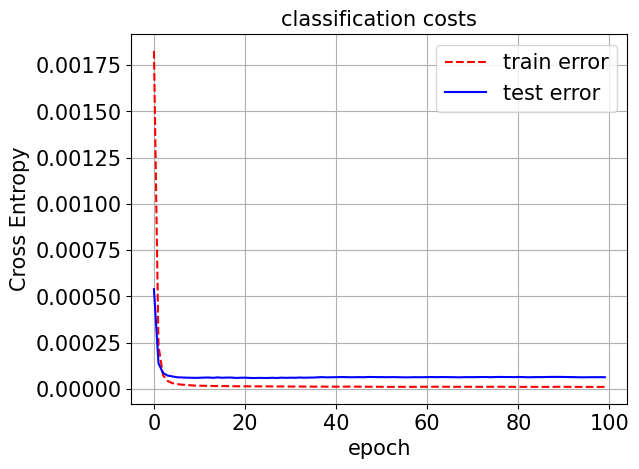

<Figure size 640x480 with 0 Axes>

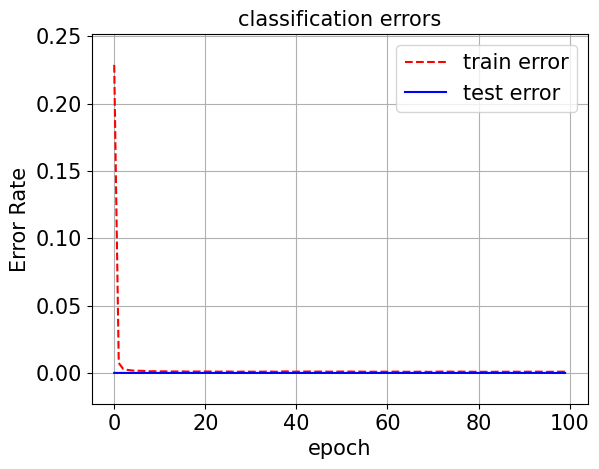

In [37]:
from train import train_BLL_classification
importlib.reload(train)

bll_cost_tr, bll_cost_dev, bll_err_tr, bll_err_dev = train_BLL_classification(
    net=bll,
    name='mnist_bll',
    batch_size=cfg.batch_size,
    nb_epochs=cfg.bll_epochs,
    trainset=trainset,
    valset=valset,
    device=cfg.device,
    burn_in=cfg.burn_in,
    sim_steps=cfg.sim_steps,
    N_saves=cfg.N_saves,
    resample_its=cfg.resample_its,
    resample_prior_its=cfg.resample_prior_its,
    re_burn=cfg.re_burn,
    nb_its_dev=cfg.nb_its_dev,
    model_saves_dir=models_dir
)


Performing final evaluation...


Evaluating: 100%|██████████| 20/20 [00:03<00:00,  5.93it/s]



Final Test Accuracy: 0.9919


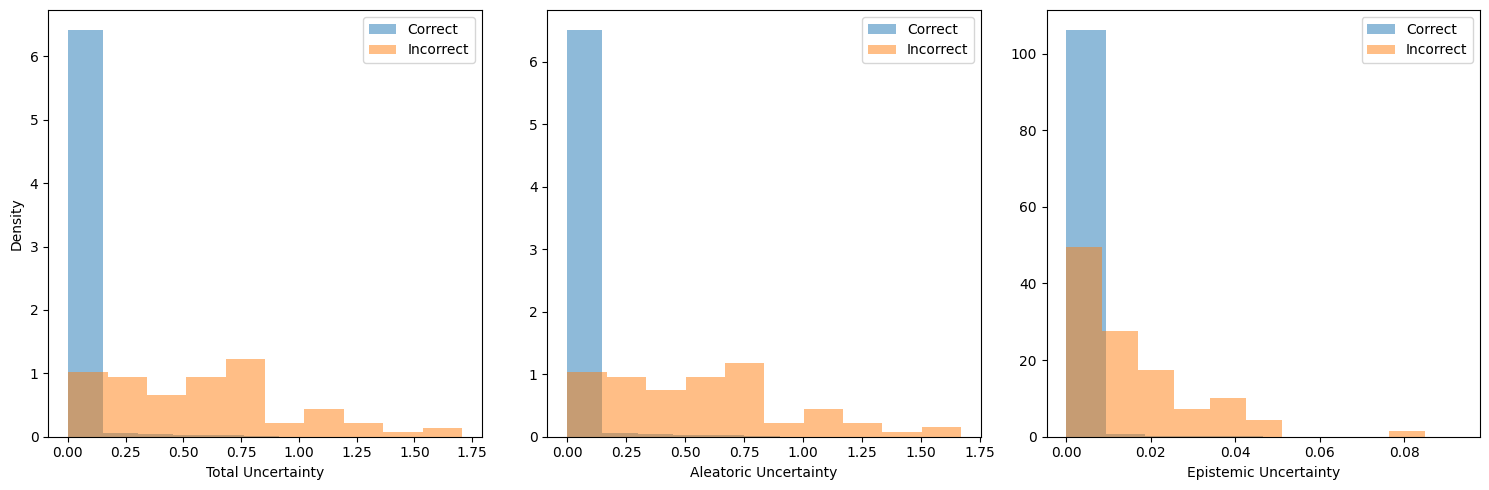

In [39]:
from tqdm import tqdm

print("\nPerforming final evaluation...")

def evaluate_uncertainty(model, loader, n_samples=None):
    correct = []
    uncertainties = {
        'total_entropy': [], 
        'aleatoric_entropy': [], 
        'epistemic_entropy': []
    }
    
    for x, y in tqdm(loader, desc="Evaluating"):
        x, y = x.to(model.device), y.to(model.device)
        probs, uncertainty = model.predict_with_uncertainty(x)
        
        # Store predictions and uncertainties
        pred = probs.argmax(dim=1)
        correct.extend((pred == y).cpu().numpy())
        
        for k, v in uncertainty.items():
            uncertainties[k].extend(v.cpu().numpy())
    
    return np.array(correct), {k: np.array(v) for k, v in uncertainties.items()}
    

# Run final evaluation
correct, uncertainties = evaluate_uncertainty(bll, testloader, cfg.N_saves)
accuracy = correct.mean()

print(f"\nFinal Test Accuracy: {accuracy:.4f}")

# 8. Visualization of Uncertainties
plt.figure(figsize=(15, 5))

# Total uncertainty
plt.subplot(131)
plt.hist(uncertainties['total_entropy'][correct], alpha=0.5, label='Correct', density=True)
plt.hist(uncertainties['total_entropy'][~correct], alpha=0.5, label='Incorrect', density=True)
plt.xlabel('Total Uncertainty')
plt.ylabel('Density')
plt.legend()

# Aleatoric uncertainty
plt.subplot(132)
plt.hist(uncertainties['aleatoric_entropy'][correct], alpha=0.5, label='Correct', density=True)
plt.hist(uncertainties['aleatoric_entropy'][~correct], alpha=0.5, label='Incorrect', density=True)
plt.xlabel('Aleatoric Uncertainty')
plt.legend()

# Epistemic uncertainty
plt.subplot(133)
plt.hist(uncertainties['epistemic_entropy'][correct], alpha=0.5, label='Correct', density=True)
plt.hist(uncertainties['epistemic_entropy'][~correct], alpha=0.5, label='Incorrect', density=True)
plt.xlabel('Epistemic Uncertainty')
plt.legend()

plt.tight_layout()
plt.show()

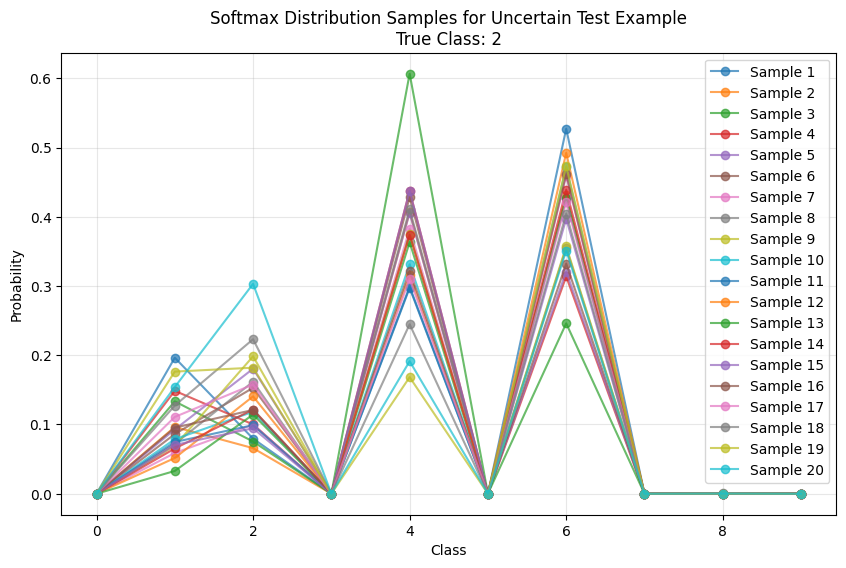

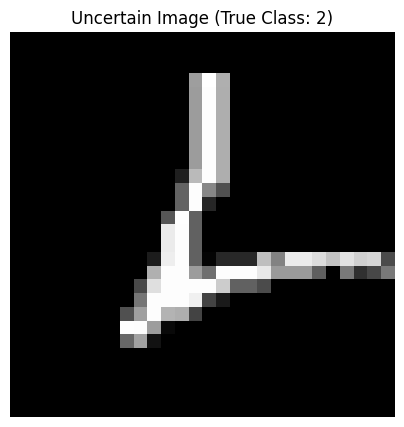

In [58]:
# Search for a test example with uncertain predictions
test_iter = iter(testloader)
found_uncertain = False
max_tries = 100

try:
    while not found_uncertain:
        x, y = next(test_iter)
        # Look at each example in the batch
        for i in range(len(x)):
            x_single = x[i:i+1]
            y_single = y[i:i+1]
            
            # Get predictions from 5 different ensemble members
            probs = bll.sample_predict(x_single, Nsamples=20)  # Shape: [5, 1, num_classes]
            probs = probs.squeeze(1)  # Remove batch dimension -> [5, num_classes]
            
            # Check if predictions are not all highly confident
            max_probs = probs.max(dim=1)[0]
            if max_probs.mean() < 0.5:  # If average confidence is less than 99.9%
                found_uncertain = True
                break
                
except StopIteration:
    if not found_uncertain:
        print("Could not find uncertain prediction in entire test set")

# Plot the softmax distributions
plt.figure(figsize=(10, 6))
x_axis = range(probs.shape[1])  # Range over number of classes

for i in range(20):
    plt.plot(x_axis, probs[i].cpu().numpy(), 'o-', alpha=0.7, label=f'Sample {i+1}')

plt.xlabel('Class')
plt.ylabel('Probability')
plt.title(f'Softmax Distribution Samples for Uncertain Test Example\nTrue Class: {y_single.item()}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Display the uncertain image
plt.figure(figsize=(5, 5))
img = x_single.squeeze().cpu()
if img.shape[0] == 1:  # If grayscale, remove channel dimension
    img = img.squeeze(0)
plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
plt.axis('off')
plt.title(f'Uncertain Image (True Class: {y_single.item()})')
plt.show()


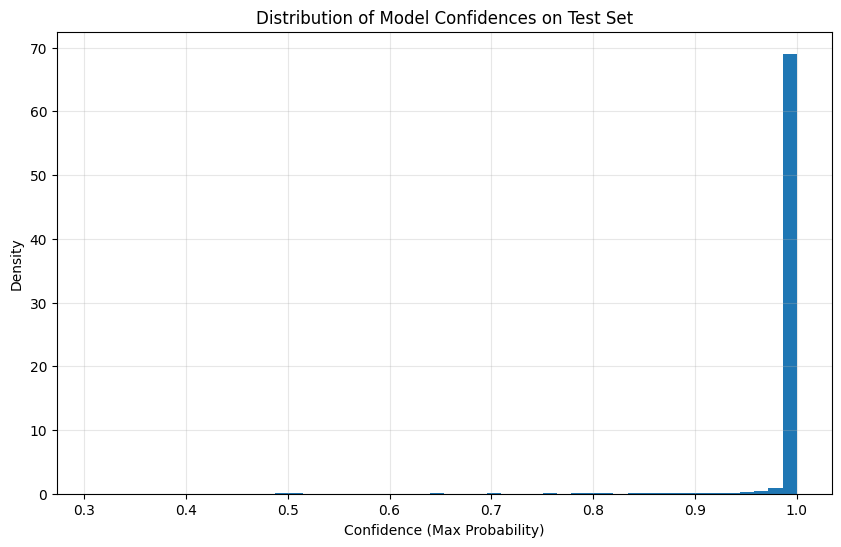

In [59]:
# Get predictions and confidences for entire test set
all_confidences = []

for x, y in testloader:
    # Get predictions from ensemble
    probs = bll.sample_predict(x)  # Shape: [n_ensemble, batch_size, num_classes]
    
    # Average probabilities across ensemble members
    mean_probs = probs.mean(dim=0)  # Shape: [batch_size, num_classes]
    
    # Get maximum probability (confidence) for each prediction
    confidences = mean_probs.max(dim=1)[0]
    all_confidences.extend(confidences.cpu().numpy())

# Plot histogram of confidences
plt.figure(figsize=(10, 6))
plt.hist(all_confidences, bins=50, density=True)
plt.xlabel('Confidence (Max Probability)')
plt.ylabel('Density')
plt.title('Distribution of Model Confidences on Test Set')
plt.grid(True, alpha=0.3)
plt.show()


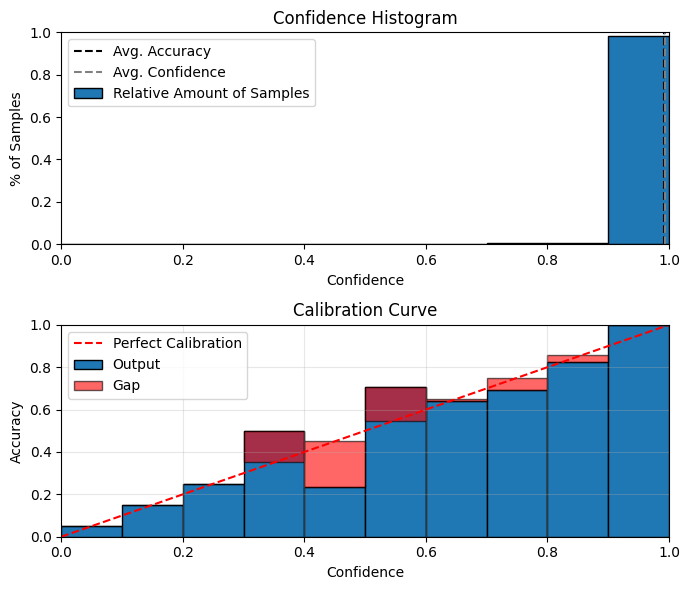

In [60]:
# Get predictions and ground truth labels for calibration curve
all_probs = []
all_labels = []

for x, y in testloader:
    # Get predictions from ensemble
    probs = bll.sample_predict(x)  # Shape: [n_ensemble, batch_size, num_classes]
    
    # Average probabilities across ensemble members
    mean_probs = probs.mean(dim=0)  # Shape: [batch_size, num_classes]
    
    all_probs.extend(mean_probs.cpu().numpy())
    all_labels.extend(y.cpu().numpy())

all_probs = np.array(all_probs)
all_labels = np.array(all_labels)

# Create reliability diagram
from netcal.presentation import ReliabilityDiagram

# Initialize reliability diagram with 10 bins
diagram = ReliabilityDiagram(10)

# Plot calibration curve
diagram.plot(all_probs, all_labels)
plt.title('Calibration Curve')
plt.grid(True, alpha=0.3)
plt.show()
